RandomForest MAE (Latitude): 0.005506912716430498
RandomForest RMSE (Latitude): 0.013416492068609214
RandomForest MAE (Longitude): 0.015496052233933995
RandomForest RMSE (Longitude): 0.03337775974194765


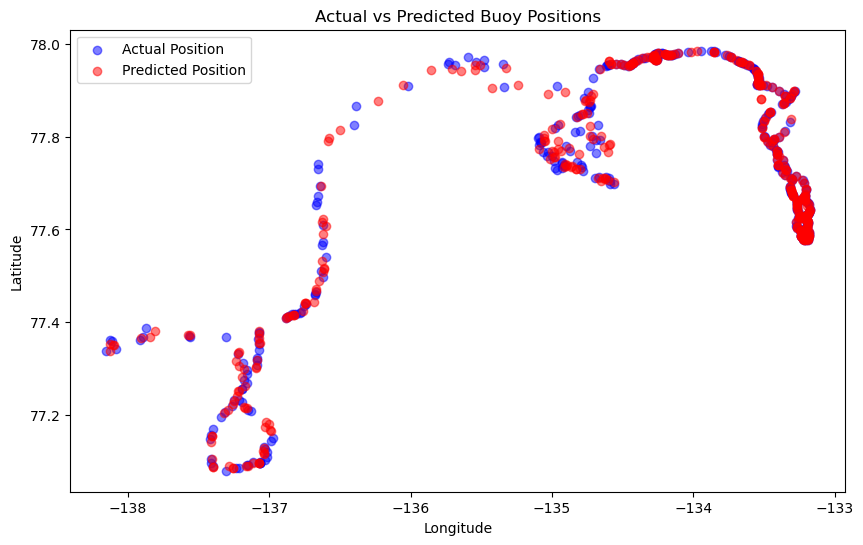

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load combined buoy data (chose 2000 rows to keep computation time simpler)
buoy_data = pd.read_csv('../combined_buoy_data.csv', nrows=2000)

# Drop missing values if any 
buoy_data = buoy_data.dropna()

# Convert 'datetime' column to datetime format if it's not already in that format
buoy_data['datetime'] = pd.to_datetime(buoy_data['datetime'])

# Function to compute wind magnitude and direction from u-wind and v-wind components
def compute_wind_features(df):
    df['wind_magnitude'] = np.sqrt(df['era5_uwnd']**2 + df['era5_vwnd']**2)
    df['wind_direction'] = np.arctan2(df['era5_vwnd'], df['era5_uwnd'])
    return df

# Apply the function to  dataset
buoy_data = compute_wind_features(buoy_data)

# Define features and target columns based on dataset structure
features = ['era5_uwnd', 'era5_vwnd', 'DOY', 'wind_magnitude', 'wind_direction']  # These are main features
target_lat = 'Latitude'  # Target for latitude prediction
target_lon = 'Longitude'  # Target for longitude prediction

# Split data into training and testing sets (for both Latitude and Longitude)
X_train_lat, X_test_lat, y_train_lat, y_test_lat = train_test_split(buoy_data[features], buoy_data[target_lat], test_size=0.2, random_state=123)
X_train_lon, X_test_lon, y_train_lon, y_test_lon = train_test_split(buoy_data[features], buoy_data[target_lon], test_size=0.2, random_state=123)

# Train RandomForest Regressor for Latitude prediction with parallel processing (n_jobs=-1 to use all cores)
rf_regressor_lat = RandomForestRegressor(n_estimators=100, random_state=123, n_jobs=-1)
rf_regressor_lat.fit(X_train_lat, y_train_lat)

# Train RandomForest Regressor for Longitude prediction with parallel processing (n_jobs=-1 to use all cores)
rf_regressor_lon = RandomForestRegressor(n_estimators=100, random_state=123, n_jobs=-1)
rf_regressor_lon.fit(X_train_lon, y_train_lon)

# Make batch predictions for Latitude and Longitude using RandomForest Regressor
lat_rf_predictions = rf_regressor_lat.predict(X_test_lat)
lon_rf_predictions = rf_regressor_lon.predict(X_test_lon)

# Evaluate performance using MAE and RMSE for Latitude predictions 
mae_rf_lat = mean_absolute_error(y_test_lat.copy(), lat_rf_predictions) 
rmse_rf_lat = np.sqrt(mean_squared_error(y_test_lat.copy(), lat_rf_predictions)) 

print(f"RandomForest MAE (Latitude): {mae_rf_lat}") 
print(f"RandomForest RMSE (Latitude): {rmse_rf_lat}")

# Evaluate performance using MAE and RMSE for Longitude predictions 
mae_rf_lon = mean_absolute_error(y_test_lon.copy(), lon_rf_predictions) 
rmse_rf_lon = np.sqrt(mean_squared_error(y_test_lon.copy(), lon_rf_predictions)) 

print(f"RandomForest MAE (Longitude): {mae_rf_lon}") 
print(f"RandomForest RMSE (Longitude): {rmse_rf_lon}")

# Plot actual vs predicted buoy positions using Matplotlib
def plot_actual_vs_predicted(y_test_lat, y_test_lon, lat_predictions, lon_predictions):
    plt.figure(figsize=(10, 6))

    # Scatter plot of actual positions (blue)
    plt.scatter(y_test_lon, y_test_lat, color='blue', label='Actual Position', alpha=0.5)

    # Scatter plot of predicted positions (red)
    plt.scatter(lon_predictions, lat_predictions, color='red', label='Predicted Position', alpha=0.5)

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Actual vs Predicted Buoy Positions')

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

# Call the function to plot actual vs predicted positions
plot_actual_vs_predicted(y_test_lat=y_test_lat,
                         y_test_lon=y_test_lon,
                         lat_predictions=lat_rf_predictions,
                         lon_predictions=lon_rf_predictions)